In [13]:
import os
import numpy as np
import pandas as pd
from IPython.display import clear_output
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
print("Setup Complete")

Setup Complete


In [145]:
run_random_search = False
league = 'premier-league'
seasons = '2017-2023'
season_test = 2022

In [146]:
# Read the data
X_full = pd.read_csv(f'./leagues_data/{league}/{seasons}.csv', index_col=0)
X_test_full = X_full[X_full['season'] == season_test]
X_full = X_full[X_full['season'] < season_test]

# Remove rows with missing target, separate target from predictors
X_full.dropna(axis=0, subset=['outcome'], inplace=True)
y = X_full.outcome
X_full.drop(['outcome', 'home_score', 'away_score'], axis=1, inplace=True)
X_full.drop(['home_odds', 'away_odds', 'draw_odds'], axis=1, inplace=True)

X_test_full.dropna(axis=0, subset=['outcome'], inplace=True)
y_test = X_test_full.outcome
X_test_full.drop(['outcome', 'home_score', 'away_score'], axis=1, inplace=True)
odds_test = X_test_full[['home_odds', 'away_odds', 'draw_odds']]
X_test_full.drop(['home_odds', 'away_odds', 'draw_odds'], axis=1, inplace=True)

display(X_full)

,game_date,season,home_team,away_team,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,...,away_away_win_pct,away_away_draw_pct,away_away_loss_pct,away_win_pct_last_games,away_draw_pct_last_games,away_loss_pct_last_games,away_score_last_games,away_conceded_last_games,away_xg_last_games,away_conceded_xg_last_games
0,2017-11-04,2017,Stoke City,Leicester City,36.666667,30.000000,20.000000,50.000000,40.000000,20.000000,...,20.000000,40.000000,40.000000,40.0,40.0,20.0,1.666667,1.333333,1.58,0.94
1,2017-11-04,2017,Southampton,Burnley,43.333333,30.000000,40.000000,30.000000,33.333333,33.333333,...,40.000000,40.000000,20.000000,40.0,40.0,20.0,0.666667,0.333333,0.60,1.18
2,2017-11-04,2017,Swansea City,Brighton,26.666667,20.000000,20.000000,60.000000,20.000000,0.000000,...,20.000000,20.000000,60.000000,40.0,40.0,20.0,1.000000,0.666667,1.00,1.28
3,2017-11-04,2017,Huddersfield,West Brom,40.000000,30.000000,30.000000,40.000000,40.000000,40.000000,...,20.000000,20.000000,60.000000,0.0,40.0,60.0,2.000000,2.500000,0.98,1.84
4,2017-11-04,2017,Newcastle Utd,Bournemouth,46.666667,40.000000,20.000000,40.000000,60.000000,20.000000,...,20.000000,0.000000,80.000000,20.0,20.0,60.0,0.000000,0.500000,0.70,1.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2022-05-22,2021,Norwich City,Tottenham,19.819820,13.513514,18.918919,67.567568,16.666667,16.666667,...,44.444444,22.222222,33.333333,60.0,40.0,0.0,2.333333,0.333333,1.52,0.78
1390,2022-05-22,2021,Manchester City,Aston Villa,81.081081,75.675676,16.216216,8.108108,77.777778,11.111111,...,38.888889,5.555556,55.555556,40.0,40.0,20.0,1.250000,1.000000,1.56,1.44
1391,2022-05-22,2021,Liverpool,Wolves,80.180180,72.972973,21.621622,5.405405,77.777778,22.222222,...,44.444444,16.666667,38.888889,0.0,40.0,60.0,0.666667,3.000000,0.94,1.82
1392,2022-05-22,2021,Burnley,Newcastle Utd,31.531532,18.918919,37.837838,43.243243,27.777778,33.333333,...,22.222222,22.222222,55.555556,60.0,0.0,40.0,1.000000,0.333333,1.08,1.42


In [147]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

def set_numerical_categorical_cols():
    # "Cardinality" means the number of unique values in a column
    # Select categorical columns with relatively low cardinality (convenient but arbitrary)
    categorical_cols = [cname for cname in X_train.columns if
                        X_train[cname].nunique() < 10 and 
                        X_train[cname].dtype == "object"]

    # Select numerical columns
    numerical_cols = [cname for cname in X_train.columns if 
                    X_train[cname].dtype in ['int64', 'float64']]
    
    return categorical_cols, numerical_cols
    

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X_full, y, 
                                                                train_size=0.8, test_size=0.2,

                                                                random_state=0)

X_train = X_train_full.copy()
X_valid = X_valid_full.copy()
X_test = X_test_full.copy()

# Define categorical and numerical columns
categorical_cols, numerical_cols = set_numerical_categorical_cols()

# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols]
X_valid = X_valid[my_cols]
X_test = X_test[my_cols]

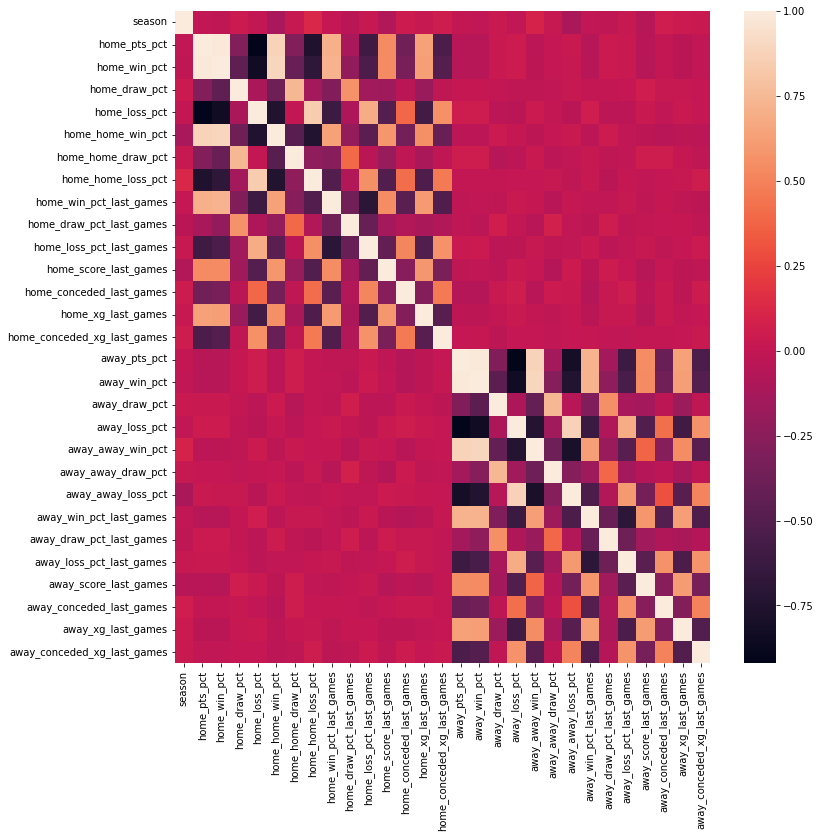

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,12))
plot_data = X_train[numerical_cols].corr()
sns.heatmap(data=plot_data) 
plt.show()

,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,away_away_win_pct,away_away_draw_pct,away_away_loss_pct,away_win_pct_last_games,away_draw_pct_last_games,away_loss_pct_last_games,away_score_last_games,away_conceded_last_games,away_xg_last_games,away_conceded_xg_last_games
1326,2021.0,38.709677,25.806452,38.709677,35.483871,31.250000,43.750000,25.000000,0.0,20.0,...,50.000000,7.142857,42.857143,40.0,0.0,60.0,1.000000,1.333333,1.38,0.76
412,2018.0,43.478261,39.130435,13.043478,47.826087,50.000000,25.000000,25.000000,20.0,20.0,...,63.636364,9.090909,27.272727,60.0,20.0,20.0,1.000000,0.500000,1.18,0.72
487,2018.0,31.111111,26.666667,13.333333,60.000000,37.500000,12.500000,50.000000,40.0,0.0,...,53.333333,6.666667,40.000000,40.0,20.0,40.0,1.500000,0.500000,1.04,1.44
1224,2021.0,38.095238,23.809524,42.857143,33.333333,36.363636,45.454545,18.181818,20.0,40.0,...,54.545455,27.272727,18.181818,40.0,40.0,20.0,3.000000,0.500000,2.02,1.12
898,2020.0,3.921569,0.000000,11.764706,88.235294,0.000000,12.500000,87.500000,0.0,20.0,...,28.571429,28.571429,42.857143,0.0,40.0,60.0,0.666667,1.000000,0.84,1.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2019.0,41.111111,36.666667,13.333333,50.000000,26.666667,13.333333,60.000000,40.0,0.0,...,13.333333,53.333333,33.333333,60.0,0.0,40.0,2.666667,0.666667,1.24,1.74
835,2019.0,48.648649,40.540541,24.324324,35.135135,44.444444,22.222222,33.333333,40.0,60.0,...,16.666667,38.888889,44.444444,20.0,40.0,40.0,0.333333,2.666667,1.02,2.18
1216,2021.0,46.296296,38.888889,22.222222,38.888889,55.555556,11.111111,33.333333,40.0,20.0,...,37.500000,25.000000,37.500000,60.0,40.0,0.0,2.666667,0.666667,2.28,0.64
559,2019.0,36.666667,30.000000,20.000000,50.000000,40.000000,40.000000,20.000000,40.0,20.0,...,80.000000,20.000000,0.000000,80.0,20.0,0.0,2.000000,1.000000,1.96,0.92


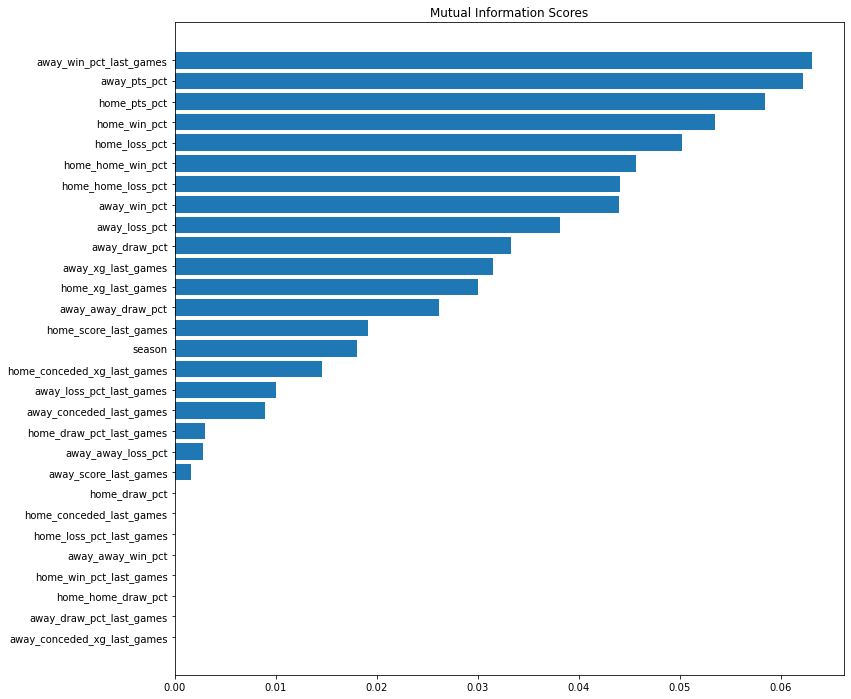

In [149]:
from sklearn.feature_selection import mutual_info_classif

def transform_x(X):
    X = X.copy()
    
    # Replacing missing values
    imputer = SimpleImputer(strategy='mean')
    X[numerical_cols] = imputer.fit_transform(X[numerical_cols])

    if categorical_cols:
        imputer = SimpleImputer(strategy='constant')
        X[categorical_cols] = imputer.fit_transform(X[categorical_cols])

    # Label encoding for categoricals
    for colname in categorical_cols:
        X[colname], _ = X[colname].factorize()
        
    return X
    

def make_mi_scores(X, y):
    # All discrete features should now have integer dtypes
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    plt.figure(figsize=(12,12))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    
X_train = transform_x(X_train)
X_valid = transform_x(X_valid)
X_test = transform_x(X_test)

display(X_train)
first_mi_scores = make_mi_scores(X_train, y_train)
plot_mi_scores(first_mi_scores)

In [150]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

def scale_values(X, features_to_explore):
    # Standardize
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X.loc[:, features_to_explore])
    return X_scaled
    
features_to_explore = [first_mi_scores.index[f] for f in range(len(first_mi_scores))]
print('Total features to consider when clustering:', len(features_to_explore))

for i in range(len(features_to_explore)):
    X_scaled = scale_values(X_train, features_to_explore[i:i+2])
    X_valid_scaled = scale_values(X_valid, features_to_explore[i:i+2])
    X_test_scaled = scale_values(X_test, features_to_explore[i:i+2])

    kmeans = KMeans(n_clusters=5, n_init=10)
    X_train[f"Cluster_{i+1}"] = kmeans.fit_predict(X_scaled)
    X_valid[f"Cluster_{i+1}"] = kmeans.predict(X_valid_scaled)
    X_test[f"Cluster_{i+1}"] = kmeans.predict(X_test_scaled)

    X_train[f"Cluster_{i+1}"] = X_train[f"Cluster_{i+1}"].astype('int')
    X_valid[f"Cluster_{i+1}"] = X_valid[f"Cluster_{i+1}"].astype('int')
    X_test[f"Cluster_{i+1}"] = X_test[f"Cluster_{i+1}"].astype('int')

Total features to consider when clustering: 29


,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,Cluster_20,Cluster_21,Cluster_22,Cluster_23,Cluster_24,Cluster_25,Cluster_26,Cluster_27,Cluster_28,Cluster_29
1326,2021.0,38.709677,25.806452,38.709677,35.483871,31.250000,43.750000,25.000000,0.0,20.0,...,2,0,4,3,2,3,1,1,2,4
412,2018.0,43.478261,39.130435,13.043478,47.826087,50.000000,25.000000,25.000000,20.0,20.0,...,3,1,2,3,2,0,2,0,0,4
487,2018.0,31.111111,26.666667,13.333333,60.000000,37.500000,12.500000,50.000000,40.0,0.0,...,2,4,2,3,1,4,2,0,1,3
1224,2021.0,38.095238,23.809524,42.857143,33.333333,36.363636,45.454545,18.181818,20.0,40.0,...,4,2,0,1,2,3,3,4,2,1
898,2020.0,3.921569,0.000000,11.764706,88.235294,0.000000,12.500000,87.500000,0.0,20.0,...,2,0,4,0,4,0,0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2019.0,41.111111,36.666667,13.333333,50.000000,26.666667,13.333333,60.000000,40.0,0.0,...,0,2,2,0,0,4,4,2,1,0
835,2019.0,48.648649,40.540541,24.324324,35.135135,44.444444,22.222222,33.333333,40.0,60.0,...,2,1,3,4,0,4,0,3,1,2
1216,2021.0,46.296296,38.888889,22.222222,38.888889,55.555556,11.111111,33.333333,40.0,20.0,...,0,3,0,2,0,4,0,3,0,4
559,2019.0,36.666667,30.000000,20.000000,50.000000,40.000000,40.000000,20.000000,40.0,20.0,...,3,4,0,1,1,2,1,0,0,1


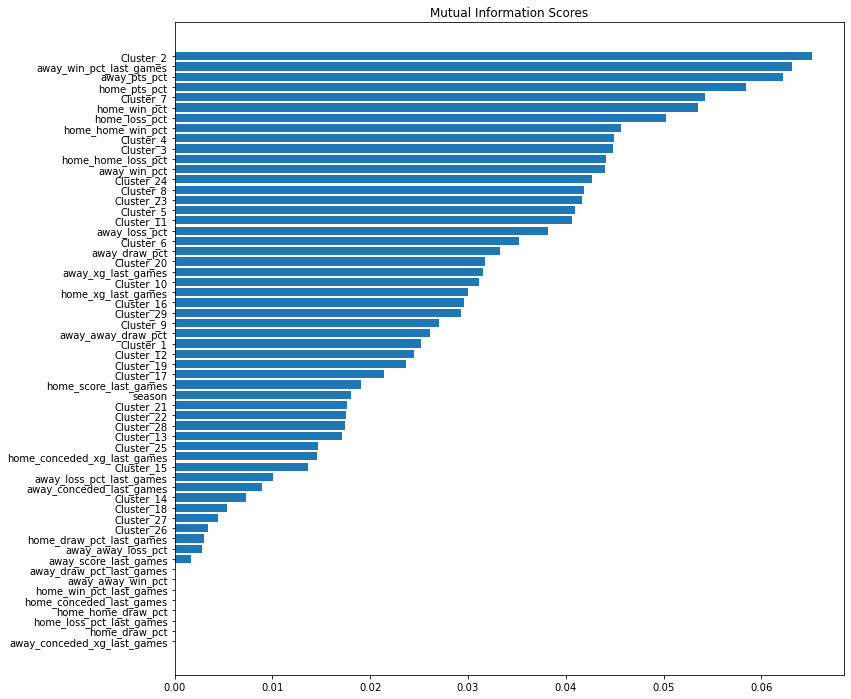

In [151]:
display(X_train)
second_mi_scores = make_mi_scores(X_train, y_train)
plot_mi_scores(second_mi_scores)

In [152]:
def get_pca(X, cols, pca, just_transform=False):
    # Standardize
    X_scaled = scale_values(X, cols)

    if just_transform:
        X_pca = pca.transform(X_scaled)
    else:
        X_pca = pca.fit_transform(X_scaled)

    # Convert to df
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names, index=X.index)
    
    X_final = pd.concat([X, X_pca], axis=1)
    return X_final

min_mi_score = 0.001
    
features_to_explore = [second_mi_scores.index[f] for f in range(len(second_mi_scores)) if second_mi_scores[f] > min_mi_score]
print('Total features to consider when doing the PCA:', len(features_to_explore))

pca = PCA()
X_train = get_pca(X_train, features_to_explore, pca)
X_valid = get_pca(X_valid, features_to_explore, pca, just_transform=True)
X_test = get_pca(X_test, features_to_explore, pca, just_transform=True)

Total features to consider when doing the PCA: 50


In [153]:
from sklearn.ensemble import RandomForestClassifier

def get_model_best_parameters(x, y):
    from sklearn.model_selection import RandomizedSearchCV

    # Gradient Boosting Optimizer
#     rs_optimizer = GradientBoostingClassifier(random_state=0)
#     # Losse functions
#     loss = ['log_loss', 'deviance', 'exponential']
#     # Learning rates
#     learning_rate = [x for x in np.linspace(0.05, 0.3, 6)]
#     # Number of estimators
#     n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    
#     random_grid = {'n_estimators': n_estimators,
#                     'loss': loss,
#                     'learning_rate': learning_rate}
    
    # Random Forest Optimizer
    rs_optimizer = RandomForestClassifier(random_state=0)
    # Number of features to consider at every split
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    max_features = ['sqrt', 'log2', None]
    # Criterion
    criterion = ['gini', 'entropy', 'log_loss']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'criterion': criterion,
                    'max_features': max_features,
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf,
                    'bootstrap': bootstrap}

    rf_random = RandomizedSearchCV(estimator = rs_optimizer, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=0, n_jobs = -1)

    rf_random.fit(x, y)

    best_random = rf_random.best_estimator_
    best_parameters = rf_random.cv_results_
#     print('Best parameters:', best_parameters)
    print('Best random:', best_random)
    
if run_random_search: get_model_best_parameters(X_train, y_train)
    
# Best models found by the RandomSearch algorithm
# GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, random_state=0)
# RandomForestClassifier(criterion='entropy', max_depth=50, max_features='log2',
#                        min_samples_leaf=2, min_samples_split=10,
#                        n_estimators=2000, random_state=0)

,season,home_pts_pct,home_win_pct,home_draw_pct,home_loss_pct,home_home_win_pct,home_home_draw_pct,home_home_loss_pct,home_win_pct_last_games,home_draw_pct_last_games,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
1326,2021.0,38.709677,25.806452,38.709677,35.483871,31.250000,43.750000,25.000000,0.0,20.0,...,-0.021838,-0.074942,-0.026222,-0.034637,0.028349,-0.044861,-0.012061,-2.157507e-15,-1.910737e-16,9.799246e-17
412,2018.0,43.478261,39.130435,13.043478,47.826087,50.000000,25.000000,25.000000,20.0,20.0,...,0.002927,0.051423,-0.071607,-0.094263,-0.010265,-0.008739,-0.039756,1.631165e-15,1.844213e-15,-9.349255e-17
487,2018.0,31.111111,26.666667,13.333333,60.000000,37.500000,12.500000,50.000000,40.0,0.0,...,0.012114,-0.022380,-0.054105,-0.064795,0.072560,-0.022802,0.032096,1.122819e-15,1.352919e-15,-5.694417e-17
1224,2021.0,38.095238,23.809524,42.857143,33.333333,36.363636,45.454545,18.181818,20.0,40.0,...,-0.073361,0.022878,-0.011674,0.032452,-0.018027,-0.011301,-0.015583,6.270154e-15,-2.855336e-16,2.498024e-16
898,2020.0,3.921569,0.000000,11.764706,88.235294,0.000000,12.500000,87.500000,0.0,20.0,...,-0.160841,0.070219,0.006107,0.014638,0.077977,-0.005497,-0.050111,4.389751e-16,2.257522e-17,-4.313298e-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,2019.0,41.111111,36.666667,13.333333,50.000000,26.666667,13.333333,60.000000,40.0,0.0,...,-0.090178,-0.057878,-0.003741,-0.089159,-0.121891,0.053884,-0.007588,4.899630e-16,8.548319e-17,1.391238e-17
835,2019.0,48.648649,40.540541,24.324324,35.135135,44.444444,22.222222,33.333333,40.0,60.0,...,0.045727,0.103632,-0.036987,-0.074457,0.097499,-0.044406,-0.041240,1.154453e-16,-3.483232e-17,-3.446439e-17
1216,2021.0,46.296296,38.888889,22.222222,38.888889,55.555556,11.111111,33.333333,40.0,20.0,...,-0.009699,-0.012186,0.042798,0.123654,0.074624,-0.048398,0.012452,1.823308e-16,-8.284828e-17,-3.981415e-17
559,2019.0,36.666667,30.000000,20.000000,50.000000,40.000000,40.000000,20.000000,40.0,20.0,...,0.131601,-0.130040,-0.080430,0.022470,0.022745,-0.053932,-0.037836,-7.205115e-16,2.525203e-16,4.921776e-17


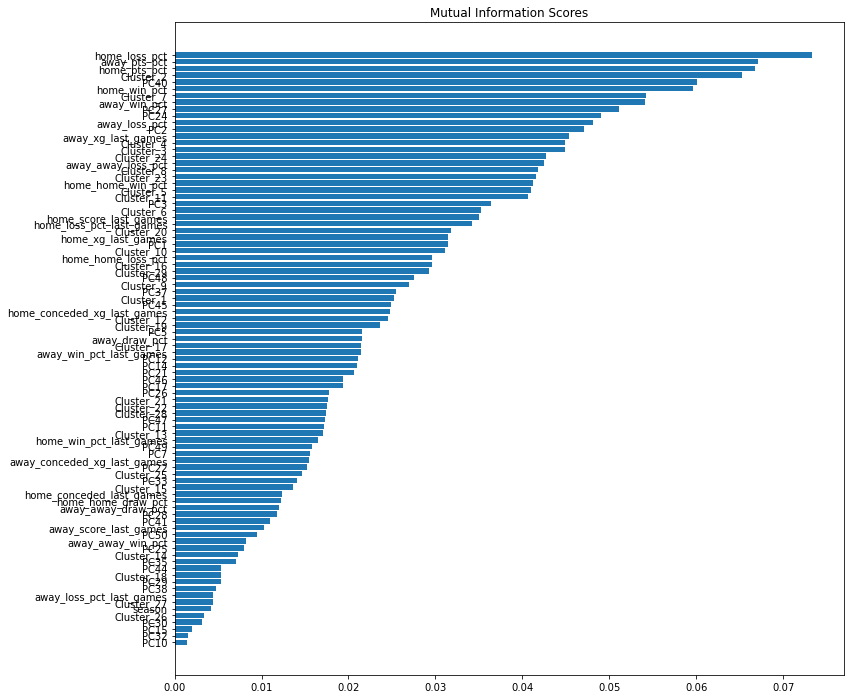

In [154]:
display(X_train)
third_mi_scores = make_mi_scores(X_train, y_train)
plot_mi_scores(third_mi_scores[third_mi_scores > min_mi_score])

In [155]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='median')

categorical_cols, numerical_cols = set_numerical_categorical_cols()

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Define normalization function
scaler = MinMaxScaler()

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('normalization', scaler, numerical_cols + categorical_cols)
    ])

# Define model, preferebly based on the RandomSearch result
# model = GradientBoostingClassifier(learning_rate=0.05, n_estimators=200, random_state=44)
model = RandomForestClassifier(criterion='entropy', max_depth=50, max_features='log2',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=2000, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)
                             ])

# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

# Evaluate the model
accuracy = accuracy_score(y_valid, preds)
print('Accuracy:', accuracy)

Accuracy: 0.5448028673835126


In [156]:
preds_test = my_pipeline.predict(X_test)

accuracy = accuracy_score(y_test, preds_test)
print('Accuracy:', accuracy)

Accuracy: 0.5440613026819924


In [157]:
test_probs = my_pipeline.predict_proba(X_test)
probs_test_df = pd.DataFrame(test_probs, index=y_test.index, columns=['away_probs', 'draw_probs', 'home_probs'])
display(probs_test_df)

,away_probs,draw_probs,home_probs
1394,0.198957,0.235798,0.565246
1395,0.268196,0.260098,0.471706
1396,0.383535,0.239113,0.377352
1397,0.108751,0.137237,0.754013
1398,0.360598,0.279171,0.360230
...,...,...,...
1650,0.331668,0.267110,0.401222
1651,0.558496,0.157574,0.283929
1652,0.317579,0.268842,0.413578
1653,0.165332,0.231040,0.603627


In [158]:
preds_test_df = pd.DataFrame(preds_test, index=y_test.index, columns=['pred'])
display(preds_test_df)

,pred
1394,H
1395,H
1396,A
1397,H
1398,A
...,...
1650,H
1651,A
1652,H
1653,H


In [159]:
test_results_df = pd.concat([y_test, preds_test_df, probs_test_df, odds_test], axis=1)
display(test_results_df)

,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds
1394,A,H,0.198957,0.235798,0.565246,2.66,2.79,3.21
1395,H,H,0.268196,0.260098,0.471706,1.67,5.31,3.90
1396,H,A,0.383535,0.239113,0.377352,2.95,2.43,3.39
1397,H,H,0.108751,0.137237,0.754013,1.23,13.00,6.68
1398,H,A,0.360598,0.279171,0.360230,2.06,3.65,3.49
...,...,...,...,...,...,...,...,...
1650,D,H,0.331668,0.267110,0.401222,3.14,2.31,3.44
1651,H,A,0.558496,0.157574,0.283929,5.18,1.64,4.16
1652,H,H,0.317579,0.268842,0.413578,2.61,2.68,3.46
1653,H,H,0.165332,0.231040,0.603627,1.21,12.68,7.30


In [160]:
def get_match_profit(row):
    if row['outcome'] == row['pred']:
        if row['pred'] == 'H': return row['home_odds'] - 1
        elif row['pred'] == 'A': return row['away_odds'] - 1
        elif row['pred'] == 'D': return row['draw_odds'] - 1
    else:
        return -1
    
test_results_df['profit'] = test_results_df.apply(lambda x: get_match_profit(x), axis=1)
display(test_results_df)
print('Model profit:', test_results_df.profit.sum())
negative_consecutive_count = test_results_df['profit'].lt(0).astype(int).groupby((test_results_df['profit'] >= 0).cumsum()).sum().max()
print('Maximum negative sequence: ', negative_consecutive_count)
positive_consecutive_count = test_results_df['profit'].gt(0).astype(int).groupby((test_results_df['profit'] < 0).cumsum()).sum().max()
print('Maximum positive sequence: ', positive_consecutive_count)

,outcome,pred,away_probs,draw_probs,home_probs,home_odds,away_odds,draw_odds,profit
1394,A,H,0.198957,0.235798,0.565246,2.66,2.79,3.21,-1.00
1395,H,H,0.268196,0.260098,0.471706,1.67,5.31,3.90,0.67
1396,H,A,0.383535,0.239113,0.377352,2.95,2.43,3.39,-1.00
1397,H,H,0.108751,0.137237,0.754013,1.23,13.00,6.68,0.23
1398,H,A,0.360598,0.279171,0.360230,2.06,3.65,3.49,-1.00
...,...,...,...,...,...,...,...,...,...
1650,D,H,0.331668,0.267110,0.401222,3.14,2.31,3.44,-1.00
1651,H,A,0.558496,0.157574,0.283929,5.18,1.64,4.16,-1.00
1652,H,H,0.317579,0.268842,0.413578,2.61,2.68,3.46,1.61
1653,H,H,0.165332,0.231040,0.603627,1.21,12.68,7.30,0.21


Model profit: 6.73
Maximum negative sequence:  7
Maximum positive sequence:  8
